#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [1]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [2]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [3]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [4]:
car_data

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
192,0,?,volkswagen,diesel,turbo,four,sedan,fwd,front,100.40,...,97,idi,3.01,3.40,23.00,68,4500,33,38,13845
157,0,91,toyota,gas,std,four,hatchback,fwd,front,95.70,...,98,2bbl,3.19,3.03,9.00,70,4800,30,37,7198
113,0,?,peugot,gas,std,four,wagon,rwd,front,114.20,...,120,mpfi,3.46,2.19,8.40,95,5000,19,24,16695
171,2,134,toyota,gas,std,two,hatchback,rwd,front,98.40,...,146,mpfi,3.62,3.50,9.30,116,4800,24,30,11549
5,2,?,audi,gas,std,two,sedan,fwd,front,99.80,...,136,mpfi,3.19,3.40,8.50,110,5500,19,25,15250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,87,toyota,gas,std,two,hatchback,fwd,front,95.70,...,92,2bbl,3.05,3.03,9.00,62,4800,35,39,5348
141,0,102,subaru,gas,std,four,sedan,fwd,front,97.20,...,108,2bbl,3.62,2.64,9.50,82,4800,32,37,7126
131,2,?,renault,gas,std,two,hatchback,fwd,front,96.10,...,132,mpfi,3.46,3.90,8.70,?,?,23,31,9895
162,0,91,toyota,gas,std,four,sedan,fwd,front,95.70,...,98,2bbl,3.19,3.03,9.00,70,4800,28,34,9258


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [5]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
5,2,?,audi,gas,std,two,sedan,fwd,front,99.80,...,136,mpfi,3.19,3.40,8.50,110,5500,19,25,15250
23,1,118,dodge,gas,turbo,two,hatchback,fwd,front,93.70,...,98,mpfi,3.03,3.39,7.60,102,5500,24,30,7957
163,1,168,toyota,gas,std,two,sedan,rwd,front,94.50,...,98,2bbl,3.19,3.03,9.00,70,4800,29,34,8058


In [6]:
LABEL = 'price'

# Select the numeric features by specifying their names
numeric_feature_names = [
    'symboling', 'normalized-losses', 'wheel-base', 'engine-size', 'bore',
    'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
    'highway-mpg'
]

# Create a list of categorical features by excluding the label
categorical_feature_names = list(set(feature_names) - {LABEL})

# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 11  # 11 numeric features
assert len(categorical_feature_names) == 25  # 25 categorical features (including label)

In [7]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [8]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
192,0,?,100.40,180.20,66.90,55.10,2579,97,68,4500,33,38,3.01,3.40,23.00
157,0,91,95.70,166.30,64.40,52.80,2109,98,70,4800,30,37,3.19,3.03,9.00
113,0,?,114.20,198.90,68.40,56.70,3285,120,95,5000,19,24,3.46,2.19,8.40
171,2,134,98.40,176.20,65.60,52.00,2714,146,116,4800,24,30,3.62,3.50,9.30
5,2,?,99.80,177.30,66.30,53.10,2507,136,110,5500,19,25,3.19,3.40,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,87,95.70,158.70,63.60,54.50,1985,92,62,4800,35,39,3.05,3.03,9.00
141,0,102,97.20,172.00,65.40,52.50,2145,108,82,4800,32,37,3.62,2.64,9.50
131,2,?,96.10,176.80,66.60,50.50,2460,132,?,?,23,31,3.46,3.90,8.70
162,0,91,95.70,166.30,64.40,52.80,2140,98,70,4800,28,34,3.19,3.03,9.00


In [9]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,body-style,num-cylinders,fuel-system,engine-location,make,engine-type,num-doors,drive-wheels,aspiration,fuel-type
192,sedan,four,idi,front,volkswagen,ohc,four,fwd,turbo,diesel
157,hatchback,four,2bbl,front,toyota,ohc,four,fwd,std,gas
113,wagon,four,mpfi,front,peugot,l,four,rwd,std,gas
171,hatchback,four,mpfi,front,toyota,ohc,two,rwd,std,gas
5,sedan,five,mpfi,front,audi,ohc,two,fwd,std,gas
...,...,...,...,...,...,...,...,...,...,...
150,hatchback,four,2bbl,front,toyota,ohc,two,fwd,std,gas
141,sedan,four,2bbl,front,subaru,ohcf,four,fwd,std,gas
131,hatchback,four,mpfi,front,renault,ohc,two,fwd,std,gas
162,sedan,four,2bbl,front,toyota,ohc,four,fwd,std,gas


In [10]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

In [11]:
column_data_types = car_data.dtypes
print(column_data_types)

car_data.describe()

car_data['compression-ratio']

object_type = type(car_data)
print(object_type)

selected_rows = car_data[4:7]
print(selected_rows)

selected_columns = car_data[['height', 'width']]
print(selected_columns)

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
                      ...   
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
Length: 26, dtype: object
<class 'pandas.core.frame.DataFrame'>
     symboling  normalized-losses    make fuel-type aspiration num-doors  \
5            2               0.00    audi       gas        std       two   
23           1             118.00   dodge       gas      turbo       two   
163          1             168.00  toyota       gas        std       two   

    body-style drive-wheels engine-location  wheel-base  ...  engine-size  \
5        sedan          fwd           front       99.80  ...          136   
23   hatchback          fwd           front       93.70  ...           98   
163      sedan          rwd           front       94.50  ...           98   

   

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [19]:
batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001),  # Adjusted learning rate and optimizer
)

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)

    # The `scores` dictionary has several metrics automatically generated by the
    # canned Estimator.
    # `average_loss` is the average loss for an individual example.
    # `loss` is the summed loss for the batch.
    # In addition to these scalar losses, you may find the visualization functions
    # in the next cell helpful for debugging model quality.
    print('scores', scores)


['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

In [16]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.keras instead.


scores {'average_loss': 34426450.0, 'label/mean': 12949.43, 'loss': 542878600.0, 'prediction/mean': 13113.016, 'global_step': 1000}


Instructions for updating:
Use standard file utilities to get mtimes.


scores {'average_loss': 28131208.0, 'label/mean': 12949.43, 'loss': 443607520.0, 'prediction/mean': 13208.442, 'global_step': 2000}


scores {'average_loss': 25887948.0, 'label/mean': 12949.43, 'loss': 408233020.0, 'prediction/mean': 13237.114, 'global_step': 3000}
scores {'average_loss': 24962316.0, 'label/mean': 12949.43, 'loss': 393636500.0, 'prediction/mean': 12994.219, 'global_step': 4000}


Instructions for updating:
Use standard file APIs to delete files with this prefix.


scores {'average_loss': 24446874.0, 'label/mean': 12949.43, 'loss': 385508380.0, 'prediction/mean': 13063.824, 'global_step': 5000}
scores {'average_loss': 24109274.0, 'label/mean': 12949.43, 'loss': 380184700.0, 'prediction/mean': 13083.944, 'global_step': 6000}
scores {'average_loss': 23847796.0, 'label/mean': 12949.43, 'loss': 376061400.0, 'prediction/mean': 13050.733, 'global_step': 7000}
scores {'average_loss': 23587696.0, 'label/mean': 12949.43, 'loss': 371959800.0, 'prediction/mean': 12964.241, 'global_step': 8000}
scores {'average_loss': 23318998.0, 'label/mean': 12949.43, 'loss': 367722660.0, 'prediction/mean': 13066.158, 'global_step': 9000}
scores {'average_loss': 23098176.0, 'label/mean': 12949.43, 'loss': 364240450.0, 'prediction/mean': 13096.264, 'global_step': 10000}


### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


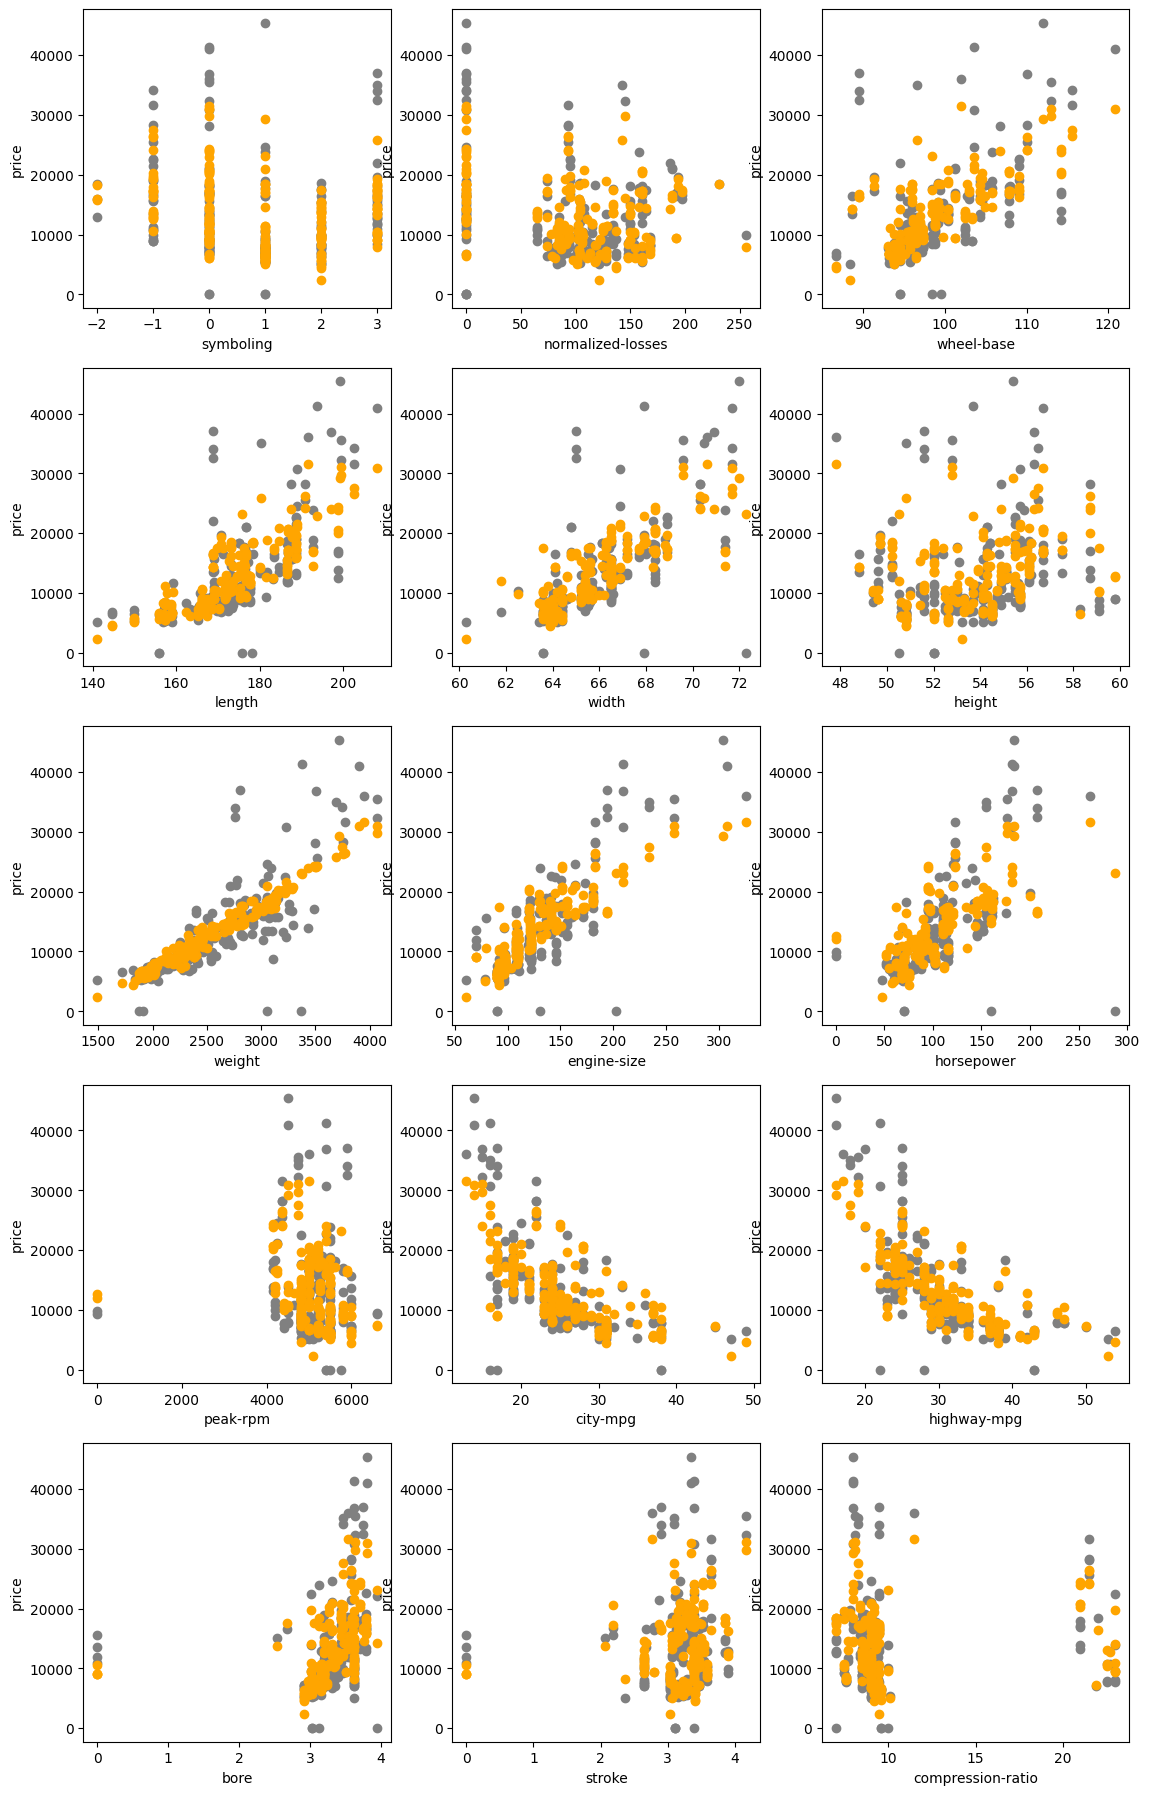

In [17]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

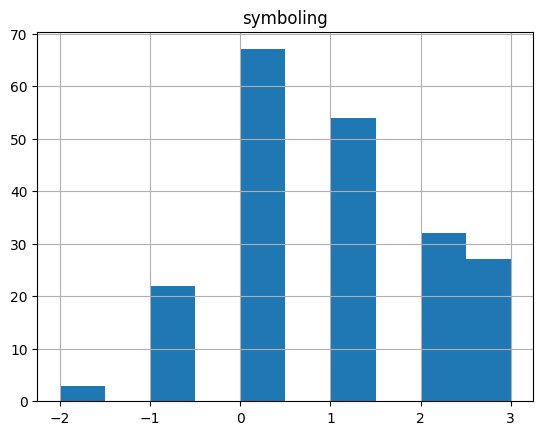

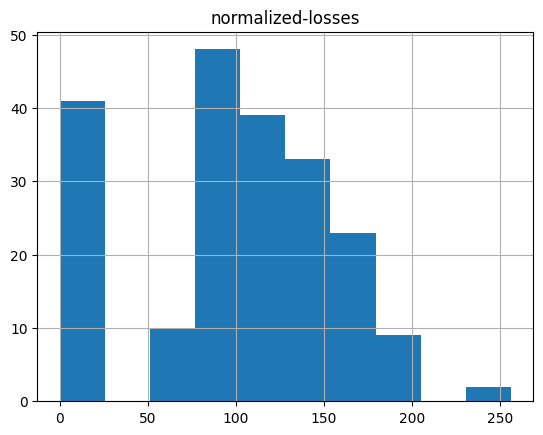

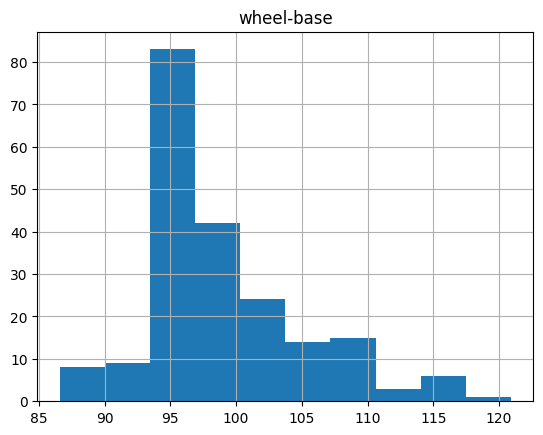

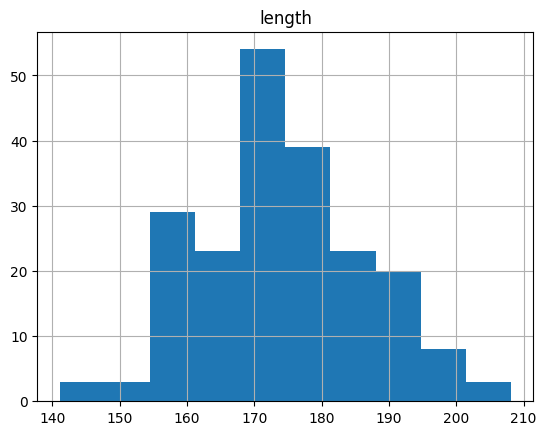

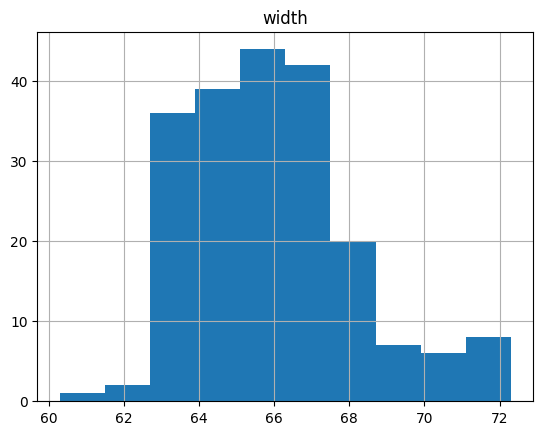

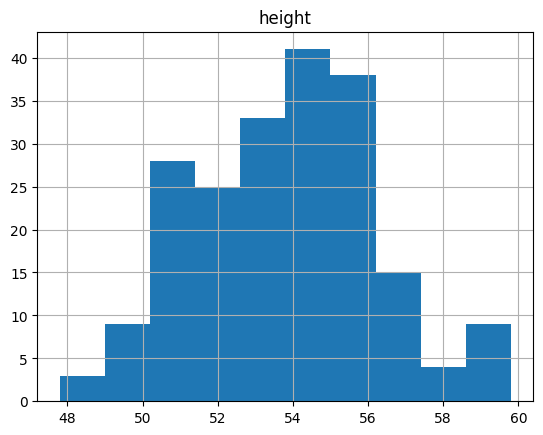

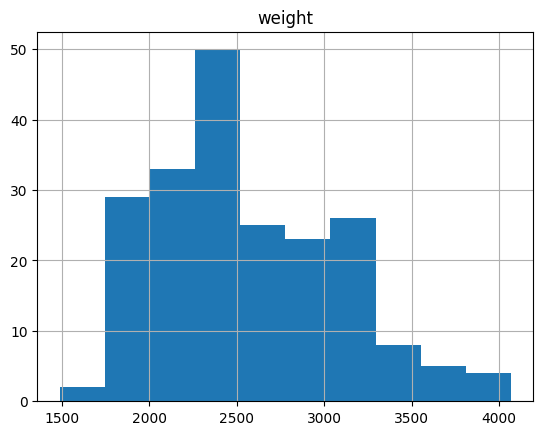

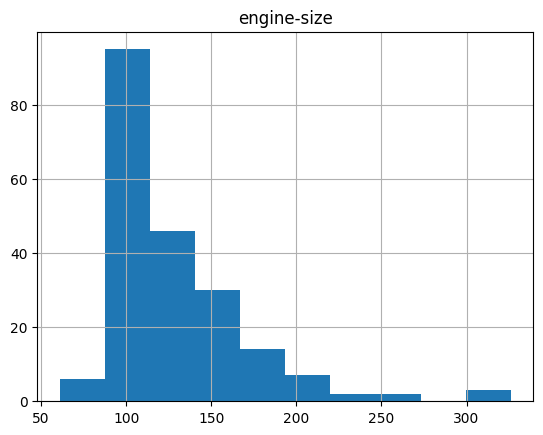

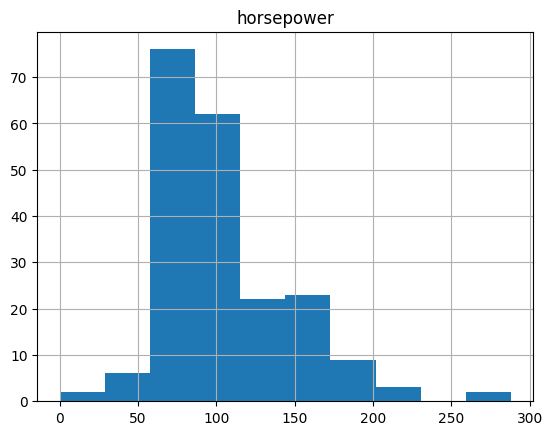

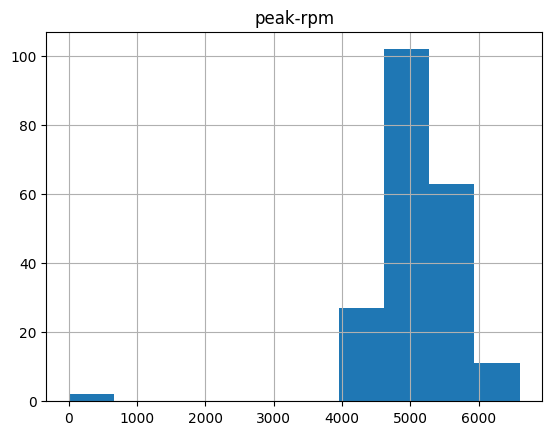

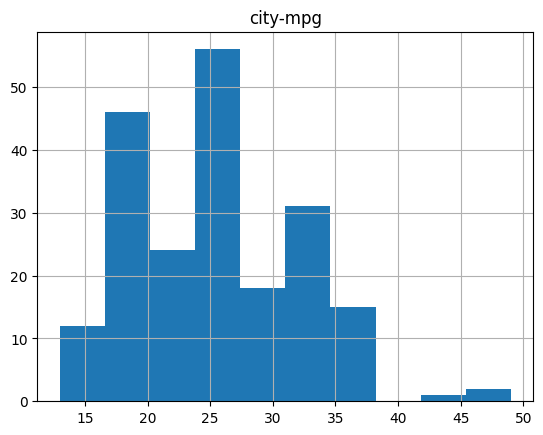

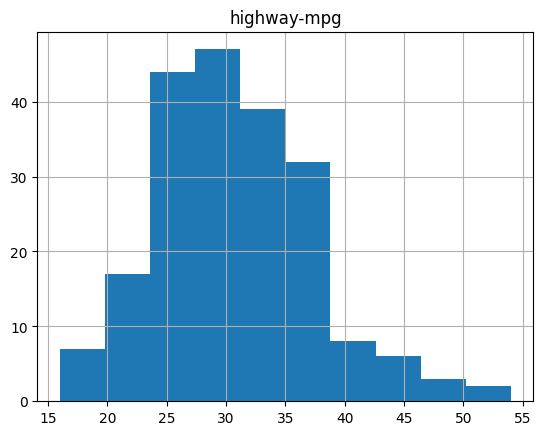

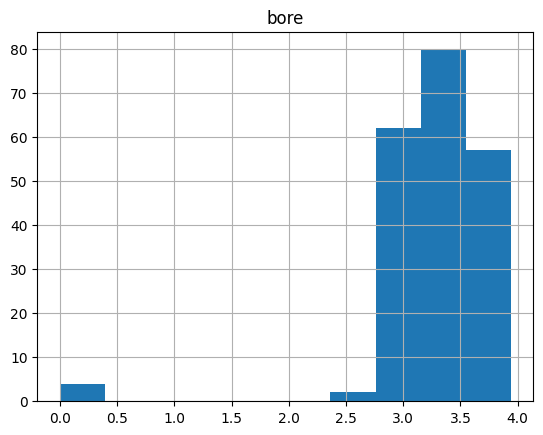

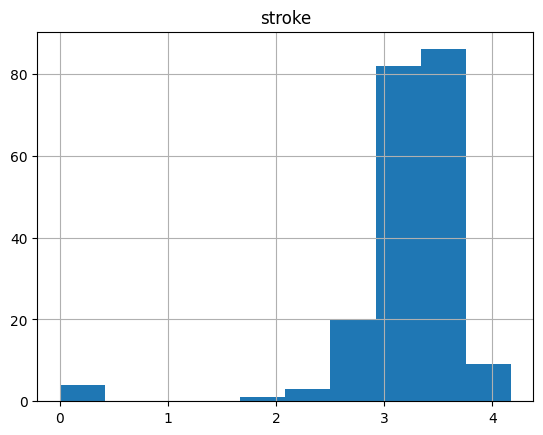

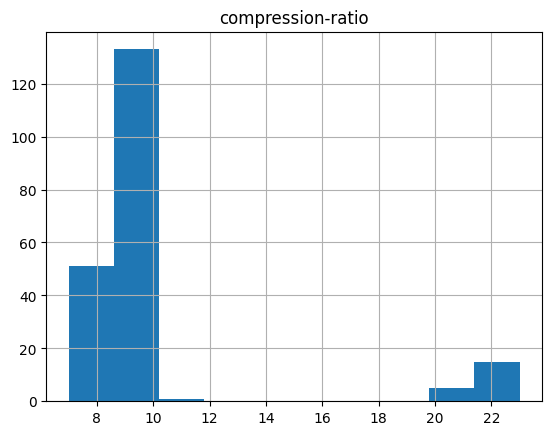

In [18]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [32]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

batch_size = 16

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.
epsilon = 0.000001

# Define a normalizer function for Z-score normalization
def z_score_normalizer(val, mean, std):
    return (val - mean) / (epsilon + std)

# Select numeric features using their column names
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Calculate mean and standard deviation for each numeric feature for normalization
numeric_means = x_df.mean()
numeric_stddevs = x_df.std()

# Apply Z-score normalization to each numeric feature
model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=lambda val, mean=numeric_means[feature_name], std=numeric_stddevs[feature_name]:
            z_score_normalizer(val, mean, std)
    )
    for feature_name in numeric_feature_names
]

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
)

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)

    print('scores', scores)


scores {'average_loss': 229102960.0, 'label/mean': 12949.43, 'loss': 3612777500.0, 'prediction/mean': 104.85966, 'global_step': 1000}
scores {'average_loss': 225035550.0, 'label/mean': 12949.43, 'loss': 3548637700.0, 'prediction/mean': 225.7415, 'global_step': 2000}
scores {'average_loss': 220833010.0, 'label/mean': 12949.43, 'loss': 3482366500.0, 'prediction/mean': 351.01398, 'global_step': 3000}
scores {'average_loss': 216645040.0, 'label/mean': 12949.43, 'loss': 3416325600.0, 'prediction/mean': 476.15906, 'global_step': 4000}
scores {'average_loss': 212513230.0, 'label/mean': 12949.43, 'loss': 3351170000.0, 'prediction/mean': 600.54407, 'global_step': 5000}
scores {'average_loss': 208390690.0, 'label/mean': 12949.43, 'loss': 3286161000.0, 'prediction/mean': 725.4623, 'global_step': 6000}
scores {'average_loss': 204275310.0, 'label/mean': 12949.43, 'loss': 3221264600.0, 'prediction/mean': 851.00745, 'global_step': 7000}
scores {'average_loss': 200236460.0, 'label/mean': 12949.43, 'lo

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7a12ab76b5b0>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7a12ab76acb0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7a12ab768700>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7a12ab76b130>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7a12ab768ca0>), NumericColumn(key='height', shape=(1,), default_va

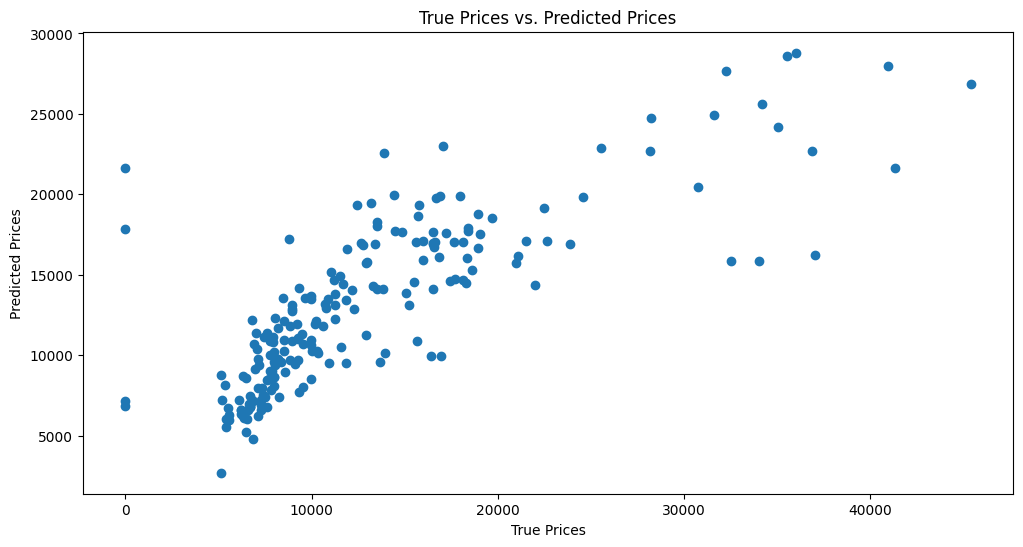

In [36]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?
import matplotlib.pyplot as plt
batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

# Generate predictions
predictions = list(est.predict(input_fn=predict_input_fn))

# Extract predicted values
predicted_values = [prediction['predictions'][0] for prediction in predictions]

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(y_series, predicted_values)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True Prices vs. Predicted Prices')
plt.show()

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [47]:
import numpy as np
import pandas as pd
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Select only the categorical features
categorical_features = car_data[categorical_feature_names]

# Define a vocabulary list for each categorical feature
categorical_columns = []
categorical_input_layers = {}  # Store input layers for each categorical feature
for feature_name in categorical_feature_names:
    unique_values = categorical_features[feature_name].unique()
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature_name,
        vocabulary_list=unique_values
    )
    categorical_columns.append(tf.feature_column.indicator_column(categorical_column))
    input_layer = tf.keras.layers.Input(shape=(1,), name=feature_name, dtype=tf.string)
    categorical_input_layers[feature_name] = input_layer

# Create a feature layer
feature_columns = categorical_columns
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Build a model using the feature layer and a dense layer
dense_inputs = {feature_name: input_layer for feature_name, input_layer in categorical_input_layers.items()}
x = feature_layer(dense_inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=dense_inputs, outputs=output)

# Initialize tables
init_op = tf.compat.v1.tables_initializer()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split the data into train and test sets
train_size = int(0.8 * len(car_data))
train_data = car_data[:train_size]
test_data = car_data[train_size:]

# Prepare the input data for training and testing
x_train = {feature_name: train_data[feature_name].values for feature_name in categorical_feature_names}
x_test = {feature_name: test_data[feature_name].values for feature_name in categorical_feature_names}
y_train = train_data[LABEL].values
y_test = test_data[LABEL].values

# Start a TensorFlow session
with tf.compat.v1.Session() as sess:
    # Initialize tables
    sess.run(init_op)

    # Train the model
    batch_size = 16
    num_epochs = 10
    model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss}")


Train on 164 samples
Epoch 1/10
164/164 [==============================] - 0s 3ms/sample - loss: 230691248.3902
Epoch 2/10
164/164 [==============================] - 0s 173us/sample - loss: 230674597.8537
Epoch 3/10
164/164 [==============================] - 0s 179us/sample - loss: 230656427.7073
Epoch 4/10
164/164 [==============================] - 0s 162us/sample - loss: 230634622.8293
Epoch 5/10
164/164 [==============================] - 0s 176us/sample - loss: 230609898.5366
Epoch 6/10
164/164 [==============================] - 0s 158us/sample - loss: 230579627.3171
Epoch 7/10
164/164 [==============================] - 0s 171us/sample - loss: 230543747.1220
Epoch 8/10
164/164 [==============================] - 0s 155us/sample - loss: 230501653.0732
Epoch 9/10
164/164 [==============================] - 0s 167us/sample - loss: 230451862.8293
Epoch 10/10
164/164 [==============================] - 0s 139us/sample - loss: 230396887.2195
Test Loss: 239980001.1707317


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [48]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('sedan', 'hatchback', 'wagon', 'hardtop', 'convertible'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'five', 'two', 'six', 'eight', 'twelve', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('idi', '2bbl', 'mpfi', '4bbl', 'spdi', 'mfi', 'spfi', '1bbl'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('volkswagen', 'toyota', 'peugot', 'audi', 

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [69]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
from tensorflow import feature_column


# Separate features and labels
X = car_data.drop(columns=['price'])
y = car_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define feature columns for numeric features
numeric_feature_names = [
    'symboling', 'normalized-losses', 'wheel-base', 'engine-size', 'bore',
    'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
    'highway-mpg'
]

numeric_feature_columns = [feature_column.numeric_column(feature_name, dtype=tf.float32) for feature_name in numeric_feature_names]

# Define feature columns for categorical features
categorical_feature_names = [
    'make', 'fuel-type', 'aspiration', 'num-doors', 'body-style',
    'drive-wheels', 'engine-location', 'engine-type', 'num-cylinders', 'fuel-system'
]

categorical_feature_columns = []

for feature_name in categorical_feature_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        key=feature_name,
        vocabulary_list=X[feature_name].unique()
    )
    categorical_feature_columns.append(feature_column.embedding_column(categorical_column, dimension=8))

# Create feature columns by combining numeric and categorical feature columns
feature_columns = numeric_feature_columns + categorical_feature_columns

# Create input functions for training and testing
def train_input_fn():
    return tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).shuffle(1000).batch(32)

def eval_input_fn():
    return tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(32)

# Create and train the model with adjusted hyperparameters
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)  # Adjusted learning rate
hidden_units = [256, 128, 64]  # Increased hidden units

model = tf.estimator.DNNRegressor(
    feature_columns=feature_columns,
    hidden_units=hidden_units,
    optimizer=optimizer,
)

num_epochs = 10  # Set the number of epochs


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train(input_fn=train_input_fn, steps=1000)

    # Evaluate the model using mean squared error (MSE)
    eval_result = model.evaluate(input_fn=eval_input_fn)
    average_loss = eval_result['average_loss']
    print('Average Loss (MSE) on test set: {average_loss:0.3f}\n'.format(average_loss=average_loss))


Epoch 1/10
Average Loss (MSE) on test set: 302155072.000

Epoch 2/10
Average Loss (MSE) on test set: 302150816.000

Epoch 3/10
Average Loss (MSE) on test set: 302146400.000

Epoch 4/10
Average Loss (MSE) on test set: 302141824.000

Epoch 5/10
Average Loss (MSE) on test set: 302136832.000

Epoch 6/10
Average Loss (MSE) on test set: 302131360.000

Epoch 7/10
Average Loss (MSE) on test set: 302125024.000

Epoch 8/10
Average Loss (MSE) on test set: 302118080.000

Epoch 9/10
Average Loss (MSE) on test set: 302110336.000

Epoch 10/10
Average Loss (MSE) on test set: 302101792.000



In [67]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=(20, 19, 13, 1, 4, 8, 14, 9, 21, 17, 10, 6, 5, 12, 18, 11, 2, 7, 15, 0, 3, 16), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=(1, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=(1, 2, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=(3, 2, 4, 1, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='drive-whe